In [1]:
import math
import numpy as np
import tomlkit
import pandas as pd
import yaml
from IPython.display import display
import importlib
import copy
import awkward as ak

import study_lib

In [2]:
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

In [8]:
importlib.reload(study_lib)
do_run = study_lib.do_run 
run_experiment = study_lib.run_experiment
config_series = study_lib.config_series

In [9]:
base_config_yaml = f"""
candidates: 4
voters: 2000
considerations:
- Issues:
    - halfcsep: 0.
      halfvsep: 0.
      sigma: {1./math.sqrt(3.)}
      uniform: true
- Issues:
    - halfcsep: 0.
      halfvsep: 0.
      sigma: {1./math.sqrt(3.)}
      uniform: true
methods:
- Plurality:
    strat: Honest
- Plurality:
    strat: Strategic
- InstantRunoff: {{}}
- Range:
    nranks: 2
    strat: Honest
- Range:
    nranks: 2
    strat: Strategic
- STAR:
    strat: Honest
- STAR:
    strat: Strategic
    strategic_stretch_factor: 2.0
- BtrIrv:
    strat: Honest
- RP:
    strat: Honest
"""
base_config = yaml.safe_load(base_config_yaml)

In [10]:
config = copy.deepcopy(base_config)
(df := run_experiment(config_series(config, 'candidates', [2, 3, 4, 5]), trials=20000, with_results=True))

,candidates,pl_h_mR,pl_s_mR,IRV_h_mR,aprv_h_mR,aprv_s_mR,star_6_h_mR,star_6_s_mR,BTR-IRV_h_mR,rp_h_mR
0,2,0.164500,0.164200,0.163700,0.164100,0.164300,0.164000,0.164300,0.163700,0.164600
1,3,0.311440,0.102263,0.102603,0.056331,0.064566,0.061446,0.070533,0.077427,0.077438
2,4,0.349505,0.131218,0.091254,0.048717,0.040083,0.031358,0.044357,0.052195,0.052585
3,5,0.390366,0.174516,0.099502,0.048306,0.033220,0.022695,0.033823,0.042583,0.040859


In [11]:
#rslt_4c = do_run(base_config, 10000)
rslt_4c = ak.from_parquet('ctr_sqz_1d_4c.parquet')

In [6]:
rslt_4c.fields

['ideal_cand',
 'cand_regret',
 'issues',
 'cov_matrix',
 'num_smith',
 'in_smith',
 'methods']

In [9]:
iss = rslt_4c.issues[:,:,0]
iss[:5]

<Array [[0.153, -0.342, ..., -0.495], ...] type='5 * option[4 * ?float64]'>

In [10]:
pl_h_winner_iss = iss[np.arange(len(iss)), rslt_4c.methods.pl_h.winner]
aprv_h_winner_iss = iss[np.arange(len(iss)), rslt_4c.methods.aprv_h.winner]
#all_iss = ak.ravel(rslt_10c.issues)
all_iss = iss[np.arange(len(iss)), np.random.randint(0,4,len(iss))]
max_util = rslt_4c.issues[:, 0, 0]

<Axes: ylabel='Density'>

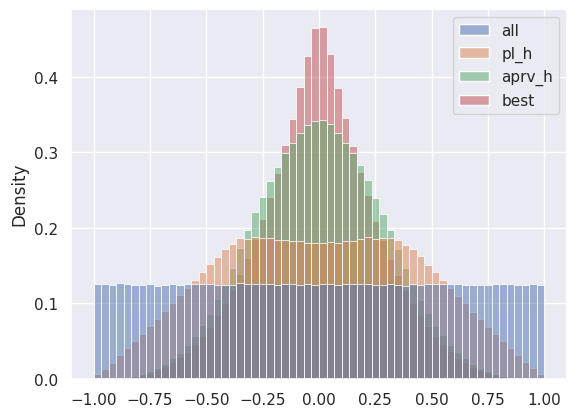

In [11]:
sns.histplot({'all':all_iss, 'pl_h':pl_h_winner_iss, 'aprv_h':aprv_h_winner_iss, 'best':max_util},
             binrange=(-1,1), bins=60, stat='density')

In [27]:
df

,candidates,pl_h_mR,pl_s_mR,IRV_h_mR,aprv_h_mR,aprv_s_mR,star_6_h_mR,star_6_s_mR,BTR-IRV_h_mR
0,2,0.019800,0.019800,0.020000,0.020400,0.019400,0.020000,0.019800,0.020000
1,3,0.405868,0.126967,0.127602,0.064416,0.003546,0.005122,0.003453,0.069578
2,4,0.525846,0.208135,0.195806,0.061940,0.010319,0.010498,0.002385,0.103047
3,5,0.637794,0.277463,0.253565,0.053060,0.012206,0.014897,0.002910,0.143972
4,8,0.891621,0.390141,0.327234,0.030092,0.009781,0.015015,0.007763,0.182100
5,13,1.061439,0.468884,0.332057,0.014648,0.004817,0.012322,0.007081,0.184403
6,21,1.105696,0.505415,0.319627,0.007724,0.002956,0.009048,0.004224,0.177960


In [29]:
df.foo = [1,2,3]

/tmp/ipykernel_30077/1286104821.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.foo = [1,2,3]


In [ ]:
ak.count_nonzero(rslt_4c.in_smith[np.arange(len(iss)), rslt_4c.methods.aprv_h.winner])

np.int64(7753)

In [15]:
ak.count_nonzero(rslt_4c.num_smith < 3)

np.int64(10000)

In [13]:
ak.count_nonzero(rslt_4c.in_smith[np.arange(len(iss)), rslt_4c.methods["BTR-IRV_h"].winner]) 

np.int64(10000)

In [44]:
rslt_4c.methods.fields

['pl_h',
 'pl_s',
 'IRV_h',
 'aprv_h',
 'aprv_s',
 'star_6_h',
 'star_6_s',
 'BTR-IRV_h',
 'rp_h']

In [12]:
ak.count_nonzero(rslt_4c.in_smith[np.arange(len(iss)), rslt_4c.methods["rp_h"].winner])

np.int64(10000)

In [12]:
def hist_1d_issue(rslt, method, ax=None, nbins=60):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    winner_iss = iss[np.arange(len(iss)), rslt_4c.methods[method].winner]
    best_iss = rslt_4c.issues[:, 0, 0]
    winner_hist, bin_edges = np.histogram(winner_iss, bins=nbins, range=(-1,1))
    best_hist, _ = np.histogram(best_iss, bins=nbins, range=(-1,1))
    bin_centers = bin_edges[:-1] + (bin_edges[-1] - bin_edges[0]) / (2 * (len(bin_edges)-1))
    winner_dist_ratio = winner_hist / best_hist
    best_theory = (1. - np.abs(bin_centers))**3 / 4. * 8
    sns.histplot(winner_iss, binrange=(-1,1), bins=60, stat='density', ax=ax)
    ax.plot(bin_centers, best_theory, '-', c='C1')
    ax2 = ax.twinx()
    ax2.semilogy(bin_centers, winner_dist_ratio, '.-')
    ax2.set_ylabel("Ratio elected / best candidate")
    ax2.set_ylim((0.1, 10.))

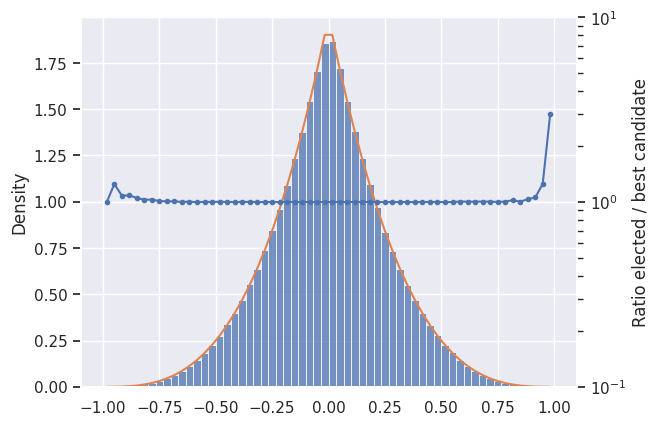

In [13]:
hist_1d_issue(rslt_4c, 'rp_h')

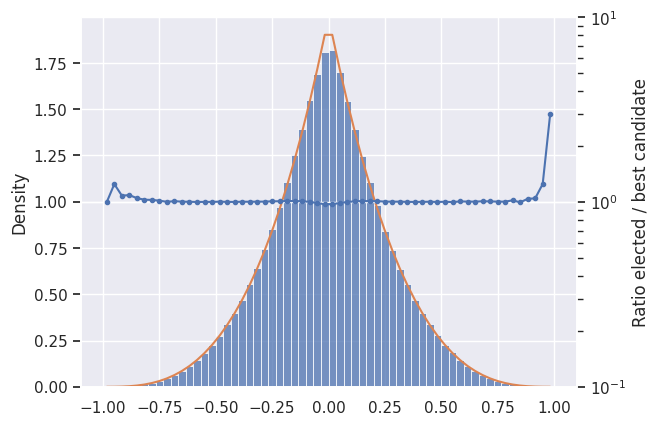

In [14]:
hist_1d_issue(rslt_4c, 'star_6_s')

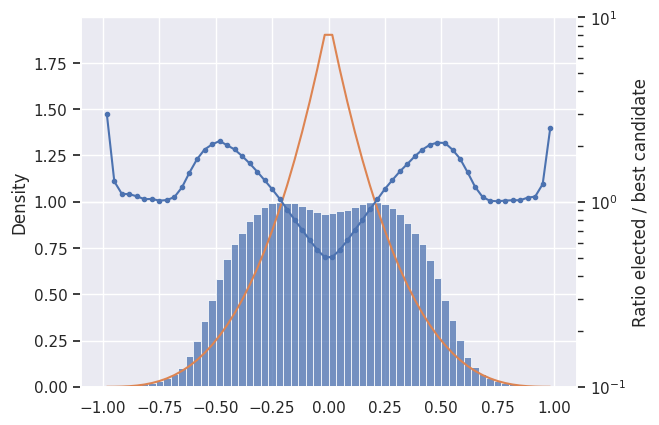

In [15]:
hist_1d_issue(rslt_4c, 'IRV_h')

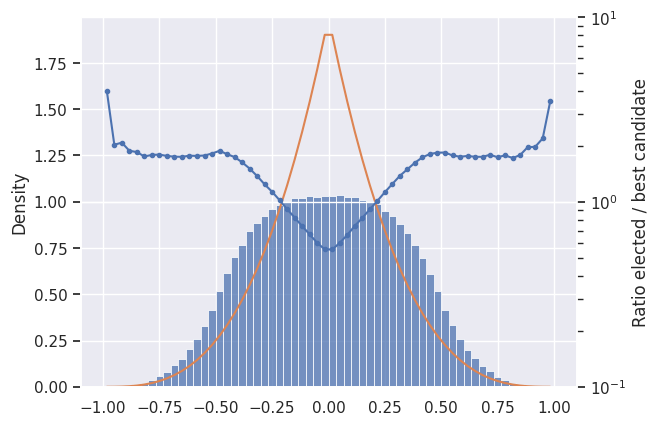

In [16]:
hist_1d_issue(rslt_4c, 'pl_s')

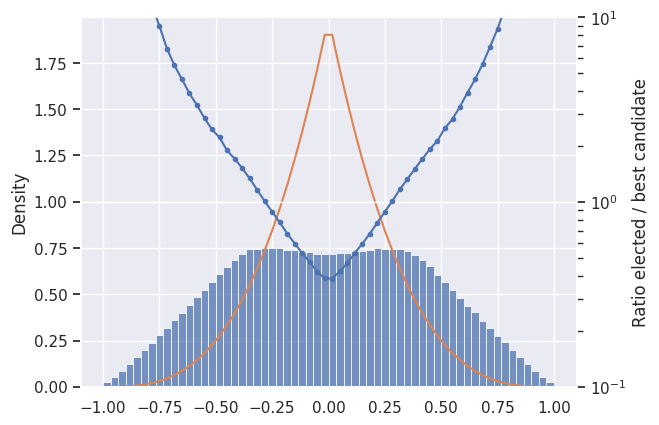

In [17]:
hist_1d_issue(rslt_4c, 'pl_h')

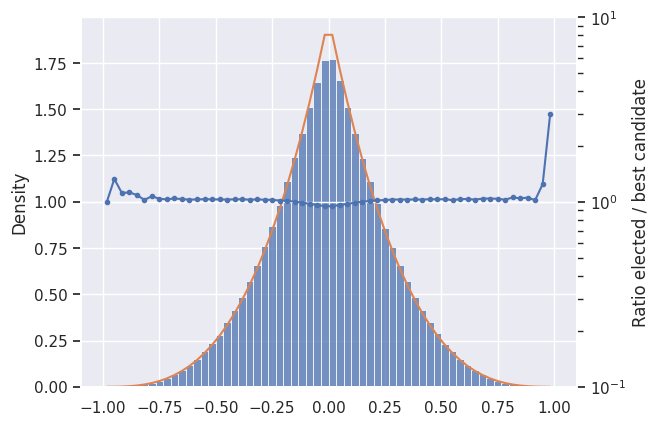

In [18]:
hist_1d_issue(rslt_4c, 'aprv_s')